In [2]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from online.envs.bidding_env import BiddingEnv
from definitions import ROOT_DIR, ENV_CONFIG_NAME
import json
from online.envs.environment_factory import EnvironmentFactory
from online.helpers import (
    load_model,
    load_vecnormalize,
)

In [3]:
def getScore_nips(total_conversions, cpa, cpa_constraint):
    beta = 2
    penalty = 1
    if cpa > cpa_constraint:
        coef = cpa_constraint / (cpa + 1e-10)
        penalty = pow(coef, beta)
    return penalty * total_conversions

In [4]:
period = 18
data_path = ROOT_DIR / "data" / "raw_traffic_final_parquet" / f"period-{period}.parquet"
raw_df = pd.read_parquet(data_path)
raw_df["real_cost"] = raw_df["cost"] * raw_df["isExposed"]


In [7]:
# score_list = []
# exp_score_list = []
# for advertiser_id in range(48):
#     total_conversions = raw_df[(raw_df.advertiserNumber == advertiser_id)].conversionAction.sum()
#     exp_total_conversions = raw_df[(raw_df.advertiserNumber == advertiser_id) & (raw_df.isExposed == 1)].pValue.sum()
#     budget = raw_df[(raw_df.advertiserNumber == advertiser_id)].budget.mean()
#     cpa_target = raw_df[(raw_df.advertiserNumber == advertiser_id)].CPAConstraint.mean()
#     total_cost = raw_df[(raw_df.advertiserNumber == advertiser_id) & (raw_df.isExposed == 1)].cost.sum()
#     cpa = total_cost / total_conversions
#     score = getScore_nips(total_conversions, cpa, cpa_target)
#     exp_score = getScore_nips(exp_total_conversions, cpa, cpa_target)
#     score_list.append(score)
#     exp_score_list.append(exp_score)
#     # print(f"Budget: {budget}, Total Cost: {total_cost}, Total Conversions: {total_conversions}, CPA Target: {cpa_target}, CPA: {cpa}, Score: {score}")
# print(np.mean(score_list))
# print(np.mean(exp_score_list))

In [8]:
# plt.plot(score_list, exp_score_list, 'o')
# plt.plot(sorted(score_list), sorted(score_list), 'r')

In [5]:
info_df = raw_df.groupby("advertiserNumber").agg({"budget": "mean", "CPAConstraint": "mean", "advertiserCategoryIndex": "mean"}).reset_index()
info_df


,advertiserNumber,budget,CPAConstraint,advertiserCategoryIndex
0,0.0,2900.000000,100.000000,0.0
1,1.0,4350.000000,69.999992,0.0
2,2.0,3000.000000,90.000008,0.0
3,3.0,2400.000000,109.999992,0.0
4,4.0,4800.000000,60.000000,0.0
5,5.0,2000.000000,130.000000,0.0
6,6.0,2050.000000,120.000000,0.0
7,7.0,3500.000000,80.000000,0.0
8,8.0,4600.000000,69.999992,1.0
9,9.0,2000.000000,130.000000,1.0


In [6]:
model_list = []
for idx, row in info_df.iterrows():
    model_list.append({
        "advertser": int(np.round(row.advertiserNumber)),
        "category": int(np.round(row.advertiserCategoryIndex)),
        "budget": int(np.round(row.budget)),
        "cpa": int(np.round(row.CPAConstraint)),
    })
print(model_list)

[{'advertser': 0, 'category': 0, 'budget': 2900, 'cpa': 100}, {'advertser': 1, 'category': 0, 'budget': 4350, 'cpa': 70}, {'advertser': 2, 'category': 0, 'budget': 3000, 'cpa': 90}, {'advertser': 3, 'category': 0, 'budget': 2400, 'cpa': 110}, {'advertser': 4, 'category': 0, 'budget': 4800, 'cpa': 60}, {'advertser': 5, 'category': 0, 'budget': 2000, 'cpa': 130}, {'advertser': 6, 'category': 0, 'budget': 2050, 'cpa': 120}, {'advertser': 7, 'category': 0, 'budget': 3500, 'cpa': 80}, {'advertser': 8, 'category': 1, 'budget': 4600, 'cpa': 70}, {'advertser': 9, 'category': 1, 'budget': 2000, 'cpa': 130}, {'advertser': 10, 'category': 1, 'budget': 2800, 'cpa': 100}, {'advertser': 11, 'category': 1, 'budget': 2350, 'cpa': 110}, {'advertser': 12, 'category': 1, 'budget': 2050, 'cpa': 120}, {'advertser': 13, 'category': 1, 'budget': 2900, 'cpa': 90}, {'advertser': 14, 'category': 1, 'budget': 4750, 'cpa': 60}, {'advertser': 15, 'category': 1, 'budget': 3450, 'cpa': 80}, {'advertser': 16, 'catego

In [7]:
row

advertiserNumber             47.0
budget                     2050.0
CPAConstraint               120.0
advertiserCategoryIndex       5.0
Name: 47, dtype: float32

In [8]:
pvalues_path = ROOT_DIR / "data" / "online_rl_data_final_with_ad_idx" / f"period-{period}_pvalues.parquet"
bids_path = ROOT_DIR / "data" / "online_rl_data_final_with_ad_idx" / f"period-{period}_bids.parquet"
budget_range = (2000, 5000)
target_cpa_range = (60, 130)
seed = 0
pv_range_list = list(np.linspace(0, 0.005, 101))
with open(ROOT_DIR / "env_configs" / f"obs_60_keys.json", "r") as f:
    obs_keys = json.load(f)
env = BiddingEnv(pvalues_path, bids_path, budget_range, target_cpa_range, obs_keys=obs_keys, exclude_self_bids=True, 
                 seed=seed, simplified_bidding=False, deterministic_conversion=False, detailed_bid=False, flex_oracle=True,
                 stochastic_exposure=True)

Loading pvalues from /home/ubuntu/Dev/NeurIPS_Auto_Bidding_General_Track_Baseline/data/online_rl_data_final_with_ad_idx/period-18_pvalues.parquet


Loading bids from /home/ubuntu/Dev/NeurIPS_Auto_Bidding_General_Track_Baseline/data/online_rl_data_final_with_ad_idx/period-18_bids.parquet


Real Conversions: 12.0, Simulated Conversions: 17


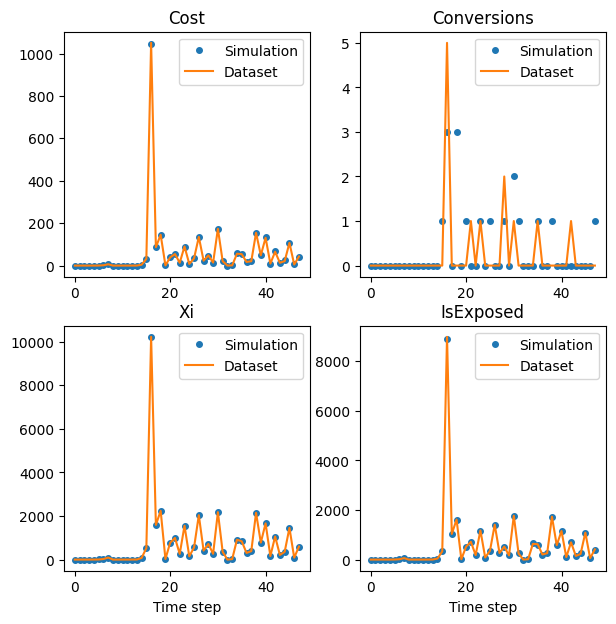

12.0 17.0


In [22]:
def compute_alpha(ad_df, ts, target_cpa):
    bids = ad_df[ad_df.timeStepIndex == ts].bid.to_numpy()
    pvalues = ad_df[ad_df.timeStepIndex == ts].pValue.to_numpy()
    alpha = np.nanmean(bids[pvalues > 0] / pvalues[pvalues > 0]) / target_cpa
    return alpha

sim_conv_list = []
real_conv_list = []
for advertiser_id in range(10, 11):
    ad_df = raw_df[raw_df.advertiserNumber == advertiser_id]

    campaign_df = ad_df.groupby("timeStepIndex").agg({
        "real_cost": "sum",
        "conversionAction": "sum",
        "xi": "sum",
        "isExposed": "sum",
        "remainingBudget": "mean"})

    ad_info = info_df[info_df.advertiserNumber == advertiser_id]
    budget = ad_info["budget"].item()
    target_cpa = ad_info["CPAConstraint"].item()

    obs, _ = env.reset(budget=budget, target_cpa=target_cpa, advertiser=advertiser_id)

    done = False
    while not done:
        step_info = campaign_df[campaign_df.index == env.time_step]
        alpha = compute_alpha(ad_df, env.time_step, target_cpa)
        obs, reward, terminated, truncated, info = env.step(alpha)
        done = terminated or truncated

    # # Make 4 subplots for cost, conversions, xi, and isExposed
    fig, axs = plt.subplots(2, 2, figsize=(7, 7))
    axs[0, 0].plot(env.history_info["cost_sum"], "o", label="Simulation", markersize=4)
    axs[0, 0].plot(campaign_df.real_cost.to_numpy(), label="Dataset")
    axs[0, 0].set_title("Cost")
    axs[0, 0].legend()
    axs[0, 1].plot(env.history_info["conversion_count"], "o", label="Simulation", markersize=4)
    axs[0, 1].plot(campaign_df.conversionAction.to_numpy(), label="Dataset")
    axs[0, 1].set_title("Conversions")
    axs[0, 1].legend()
    axs[1, 0].plot(env.history_info["bid_success_count"], "o", label="Simulation", markersize=4)
    axs[1, 0].plot(campaign_df.xi.to_numpy(), label="Dataset")
    axs[1, 0].set_title("Xi")
    axs[1, 0].legend()
    axs[1, 1].plot(env.history_info["exposure_count"], "o", label="Simulation", markersize=4)
    axs[1, 1].plot(campaign_df.isExposed.to_numpy(), label="Dataset")
    axs[1, 1].set_title("IsExposed")
    axs[1, 1].legend()
    axs[1, 0].set_xlabel("Time step")
    axs[1, 1].set_xlabel("Time step")


    # Compare number of conversions
    real_conversions = campaign_df.conversionAction.sum()
    sim_conversions = np.sum(env.history_info["conversion_count"])
    real_conv_list.append(real_conversions)
    sim_conv_list.append(sim_conversions)
    print(f"Real Conversions: {real_conversions}, Simulated Conversions: {sim_conversions}")
    plt.savefig(f"advertiser_{advertiser_id}_period_{period}.png", dpi=300, bbox_inches="tight")
    plt.show()
print(np.mean(real_conv_list), np.mean(sim_conv_list))


In [12]:
# advertiser_id = 18
# ts = 10
# env.reset(advertiser=advertiser_id, budget=2000, target_cpa=100)
# pvalues = env.episode_pvalues_df[env.episode_pvalues_df.timeStepIndex == ts].pValue.item()

# ad_df = raw_df[raw_df.advertiserNumber == advertiser_id]
# pvalues_origin = ad_df[ad_df.timeStepIndex == ts].pValue.to_numpy()

In [13]:
# np.mean(pvalues_origin), np.mean(pvalues)

In [14]:
# exp_path = "053_onbc_seed_0_new_data_realistic_60_obs_resume_050"
# checkpoint = 13170000

# experiment_path = ROOT_DIR / "output" / "training" / "ongoing" / exp_path
# model = load_model(
#     "onbc",
#     experiment_path,
#     checkpoint,
# )
# train_env_config = json.load(open(experiment_path / ENV_CONFIG_NAME, "r"))
# train_env_config["bids_df_path"] = None
# train_env_config["pvalues_df_path"] = None
# train_env = EnvironmentFactory.create(**train_env_config)
# vecnormalize = load_vecnormalize(experiment_path, checkpoint, train_env)
# vecnormalize.training = False


In [15]:
# advertiser_id = 8

# ad_df = raw_df[raw_df.advertiserNumber == advertiser_id]

# campaign_df = ad_df.groupby("timeStepIndex").agg({
#     "real_cost": "sum",
#     "conversionAction": "sum",
#     "xi": "sum",
#     "isExposed": "sum",
#     "remainingBudget": "mean"})

# ad_info = info_df[info_df.advertiserNumber == advertiser_id]
# budget = ad_info["budget"].item()
# target_cpa = ad_info["CPAConstraint"].item()

# obs, _ = env.reset(budget=budget, target_cpa=target_cpa, advertiser=advertiser_id)

# done = False
# while not done:
#     pvalues, pvalue_sigmas = env.unwrapped.get_pvalues_mean_and_std()
#     state_dict = env.unwrapped.get_state_dict(pvalues, pvalue_sigmas)
#     state = train_env.unwrapped.get_state(state_dict)
#     norm_obs = vecnormalize.normalize_obs(state)
#     action, _ = model.predict(
#         norm_obs,
#         deterministic=True,
#     )
#     bid_coef = train_env.unwrapped.compute_bid_coef(
#         action, pvalues, pvalue_sigmas
#     )
#     bids = bid_coef * env.unwrapped.target_cpa
#     _, reward, terminated, truncated, info = env.unwrapped.place_bids(
#         bids, pvalues, pvalue_sigmas
#     )
#     done = terminated or truncated

# # Make 4 subplots for cost, conversions, xi, and isExposed
# fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# axs[0, 0].plot(env.history_info["cost_sum"], "o", label="Simulation")
# axs[0, 0].plot(campaign_df.real_cost.to_numpy(), label="Dataset")
# axs[0, 0].set_title("Cost")
# axs[0, 0].legend()
# axs[0, 1].plot(env.history_info["conversion_count"], "o", label="Simulation")
# axs[0, 1].plot(campaign_df.conversionAction.to_numpy(), label="Dataset")
# axs[0, 1].set_title("Conversions")
# axs[0, 1].legend()
# axs[1, 0].plot(env.history_info["bid_success_count"], "o", label="Simulation")
# axs[1, 0].plot(campaign_df.xi.to_numpy(), label="Dataset")
# axs[1, 0].set_title("Xi")
# axs[1, 0].legend()
# axs[1, 1].plot(env.history_info["exposure_count"], "o", label="Simulation")
# axs[1, 1].plot(campaign_df.isExposed.to_numpy(), label="Dataset")
# axs[1, 1].set_title("IsExposed")
# axs[1, 1].legend()

# # Compare number of conversions
# real_conversions = campaign_df.conversionAction.sum()
# sim_conversions = np.sum(env.history_info["conversion_count"])
# real_conv_list.append(real_conversions)
# sim_conv_list.append(sim_conversions)
# print(f"Real Conversions: {real_conversions}, Simulated Conversions: {sim_conversions}")

# plt.show()


In [31]:
exp_path = "053_onbc_seed_0_new_data_realistic_60_obs_resume_050"
checkpoint = 13170000
dataset_id = 1

experiment_path = ROOT_DIR / "output" / "training" / "ongoing" / exp_path
model = load_model(
    "onbc",
    experiment_path,
    checkpoint,
)
train_env_config = json.load(open(experiment_path / ENV_CONFIG_NAME, "r"))
train_env_config["bids_df_path"] = None
train_env_config["pvalues_df_path"] = None
train_env = EnvironmentFactory.create(**train_env_config)
vecnormalize = load_vecnormalize(experiment_path, checkpoint, train_env)
vecnormalize.training = False


env path /home/ubuntu/Dev/NeurIPS_Auto_Bidding_General_Track_Baseline/output/training/ongoing/053_onbc_seed_0_new_data_realistic_60_obs_resume_050/rl_model_vecnormalize_13170000_steps.pkl


In [32]:
num_advertisers = 48
num_time_steps = 48
period_list = np.arange(7, 28)

for period in period_list:
    print("Period", period)
    pvalues_path = ROOT_DIR / "data" / "online_rl_data_final_with_ad_idx" / f"period-{period}_pvalues.parquet"
    bids_path = ROOT_DIR / "data" / "online_rl_data_final_with_ad_idx" / f"period-{period}_bids.parquet"
    
    with open(ROOT_DIR / "env_configs" / f"obs_60_keys.json", "r") as f:
        obs_keys = json.load(f)
    env = BiddingEnv(pvalues_path, bids_path, obs_keys=obs_keys, exclude_self_bids=True, 
                    seed=0, simplified_bidding=False, deterministic_conversion=False,
                    stochastic_exposure=False)
    
    bids_per_ts_list = [[] for _ in  range(num_time_steps)]

    for advertiser_id in range(num_advertisers):
        print(f"Advertiser: {advertiser_id}")
        ad_info = info_df[info_df.advertiserNumber == advertiser_id]
        budget = ad_info["budget"].item()
        target_cpa = ad_info["CPAConstraint"].item()

        obs, _ = env.reset(budget=budget, target_cpa=target_cpa, advertiser=advertiser_id)

        done = False
        ts = 0
        while not done:
            pvalues, pvalue_sigmas = env.unwrapped.get_pvalues_mean_and_std()
            state_dict = env.unwrapped.get_state_dict(pvalues, pvalue_sigmas)
            state = train_env.unwrapped.get_state(state_dict)
            norm_obs = vecnormalize.normalize_obs(state)
            action, _ = model.predict(
                norm_obs,
                deterministic=True,
            )
            bid_coef = train_env.unwrapped.compute_bid_coef(
                action, pvalues, pvalue_sigmas
            )
            bids = bid_coef * env.unwrapped.target_cpa
            _, reward, terminated, truncated, info = env.unwrapped.place_bids(
                bids, pvalues, pvalue_sigmas
            )
            bids_per_ts_list[ts].append(bids)
            done = terminated or truncated
            ts += 1
        assert ts == 48, ts
    
    bids_df = env.bids_df_list.copy()
    bids_df.deliveryPeriodIndex += 28 * dataset_id
    
    # Update the dataset with the collected bids
    for ts in range(num_time_steps):
        bids = np.stack(bids_per_ts_list[ts]).transpose()
        sort_idx = np.argsort(bids, axis=1)
        num_impressions = bids.shape[0]

        top_bids_ids = sort_idx[:, -3:]
        top_cost_ids = sort_idx[:, -4:-1]
        top_bids = np.take_along_axis(bids, top_bids_ids, axis=1)
        top_bid_costs = np.take_along_axis(bids, top_cost_ids, axis=1)
        
        # Select rows where timeStepIndex equals current ts
        mask = bids_df.timeStepIndex == ts
        idx = bids_df.index[mask].item()

        bids_df.at[idx, "bid"] = top_bids
        bids_df.at[idx, "cost"] = top_bid_costs
        bids_df.at[idx, "advertiserNumber"] = top_bids_ids
    bids_df["bid"] = bids_df["bid"].apply(lambda x: x.tolist())
    bids_df["cost"] = bids_df["cost"].apply(lambda x: x.tolist())
    bids_df["advertiserNumber"] = bids_df["advertiserNumber"].apply(lambda x: x.tolist())
    # bids_df["conversionAction"] = bids_df["conversionAction"].apply(lambda x: x.tolist())
    bids_df["isExposed"] = bids_df["isExposed"].apply(lambda x: x.tolist())

    out_path = ROOT_DIR / "data" / "online_rl_data_final_expert_bids" / f"period-{period}_bids_{dataset_id}.parquet"
    print("Saving to", out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    bids_df.to_parquet(out_path)



Period 7
Loading pvalues from /home/ubuntu/Dev/NeurIPS_Auto_Bidding_General_Track_Baseline/data/online_rl_data_final_with_ad_idx/period-7_pvalues.parquet


Loading bids from /home/ubuntu/Dev/NeurIPS_Auto_Bidding_General_Track_Baseline/data/online_rl_data_final_with_ad_idx/period-7_bids.parquet
Advertiser: 0
Advertiser: 1
Advertiser: 2
Advertiser: 3
Advertiser: 4
Advertiser: 5
Advertiser: 6
Advertiser: 7
Advertiser: 8
Advertiser: 9
Advertiser: 10
Advertiser: 11
Advertiser: 12
Advertiser: 13
Advertiser: 14
Advertiser: 15
Advertiser: 16
Advertiser: 17
Advertiser: 18
Advertiser: 19
Advertiser: 20
Advertiser: 21
Advertiser: 22
Advertiser: 23
Advertiser: 24
Advertiser: 25
Advertiser: 26
Advertiser: 27
Advertiser: 28
Advertiser: 29
Advertiser: 30
Advertiser: 31
Advertiser: 32
Advertiser: 33
Advertiser: 34
Advertiser: 35
Advertiser: 36
Advertiser: 37
Advertiser: 38
Advertiser: 39
Advertiser: 40
Advertiser: 41
Advertiser: 42
Advertiser: 43
Advertiser: 44
Advertiser: 45
Advertiser: 46
Advertiser: 47
Saving to /home/ubuntu/Dev/NeurIPS_Auto_Bidding_General_Track_Baseline/data/online_rl_data_final_expert_bids/period-7_bids_1.parquet
Period 8
Loading p